# BIBLIOGRAFÍA: 
https://bmcnoldy.rsmas.miami.edu/tropics/oni/

https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php
 




---


# Cálculo del ÍNDICE OCÉANICO NIÑO (ONI) Utilizando la metodología del Centro de Predicción Climática de la NOAA.

---



In [1]:
import warnings # Omitir mensajes de advertencia
warnings.filterwarnings("ignore")

In [2]:
# Trabajamos en colab: 
from google.colab import drive 
drive.mount('/content/drive/')

import os

path = '/content/drive/MyDrive/Colab Notebooks/GRAFICAS_IOA/ONI-SOI-CORR/' # Directorio de trabajo
os.chdir(path) 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
#!pip install 'xarray == 0.19.0'
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
ds= xr.open_dataset(path + 'noaa.ersst.v5_sst.mnmean.nc', decode_times = False,drop_variables = ['time_bnds'])
ds['time'] = pd.date_range('1854-01-01', '2022-11-01', freq = 'MS')
# CAMBIANDO EL ORDEN DE LA LATITUD
lat = np.arange(-88.0, 90.0, 2)
ds['lat'] = lat
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 2027)
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2022-11-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2022-12-04

# GRAFICAMOS LAS CLIMATOLOGÍAS ACTUALIZADAS (CLIMATOLOGÍA AJUSTADA) CADA 5 AÑOS 

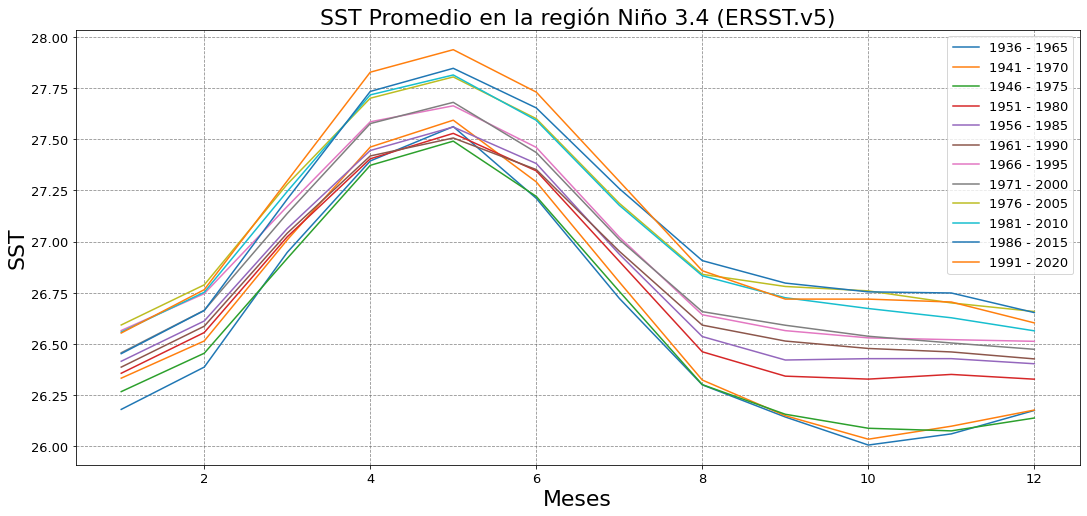

In [5]:
# Definir el tamaño del intervalo para la climatología
clim_size = 30 # Tamaño de la climatología 
clim_step = 5 # Actualizaciones (cada 5 años) 

# Definir los años de inicio y fin para cada climatología
start_years = range(1936, 2021 - clim_size + 1, clim_step)
end_years = [start_year + clim_size - 1 for start_year in start_years]

clims = {}
lista = [] 

# Tamaño de la gráfica: 
fig, ax = plt.subplots(figsize=(18,8))
# Iterar sobre los años de inicio y fin para cada climatología
for i in range(len(start_years)):
    # Seleccionar los datos para el intervalo de tiempo deseado
    start_year = start_years[i]
    end_year = end_years[i]
    clim = ds.sel(time=slice(f'{start_year}', f'{end_year}')).groupby('time.month').mean(dim='time')
    # Seleccionar los datos solo para la región niño 3.4
    clim = clim.sel(lat=slice(-5,5), lon=slice(190, 240)).mean(['lat','lon']) # Promediamos grillas para obtener series de tiempo
    # Almacenar la climatología en el diccionario
    clims[f'{start_year} - {end_year}'] = clim 
    # Almacenar las climatologías en la lista 
    lista.append(clim.sst.values)

    clim.sst.plot(label=f"{start_years[i]} - {end_years[i]+clim_step-5}")
    
# Agregar etiquetas y títulos al gráfico
plt.title('SST Promedio en la región Niño 3.4 (ERSST.v5)', fontsize = 22)
ax.grid(axis='x', linestyle = '--', alpha = 0.75, color = 'dimgrey')
ax.grid(axis='y', linestyle = '--', alpha = 0.75, color = 'dimgrey')
ax.set_ylabel('SST',fontsize = 22)
ax.set_xlabel('Meses',fontsize = 22)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
ax.legend(fontsize = 13)
plt.show()
fig.savefig(path + f'N-composites2.jpg', 
                 transparent = False, pad_inches = 0.1, dpi = 700, bbox_inches = 'tight')  



---


# CALCULANDO EL ÍNDICE ONI 

---



## Para calcular el índice ONI primero debemos de calcular las climatologías en la región niño 3.4. Partiendo de los datos originales. Luego crearemos un DataFrame con los valores de las climatologías de los datos originales y las climatologías ajustadas. Las Anomalías vendrían a ser la diferencia entre esas dos: Climatología Original - Climatología Ajustada. El Índice ONI está dado por la media movil de 3 meses consecutivos de las anomalías calculadas. 

In [6]:
# SELECCIONAMOS LA REGIÓN 3.4:
sst_nino34 = ds.sst.sel(lat=slice(-5, 5), lon=slice(190, 240)).mean(['lat','lon'])
sst_nino34 

<xarray.DataArray 'sst' (time: 2027)>
array([25.897709, 26.05581 , 26.908752, ..., 25.638582, 25.718513,
       25.793142], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2022-11-01

In [19]:
time = pd.date_range('1951-01-01', '2022-11-01', freq = 'MS')
len(time) # 863 filas 

863

In [8]:
# Creamos un DataFrame con los valores 
df = pd.DataFrame(lista)
# Necesitamos ordenar los datos del DataFrame de manera vertical 
ga = df.transpose() # Pasamos las filas a columnas 
copies = [ga] * 6 # Multiplicamos las columnas 
nuevo_df = pd.concat(copies) # Concatenamos 
df_largo = nuevo_df.melt().set_index(time) # Ordenamos verticalmente y colocamos como índice a time 
# Eliminamos la columna 'variable' y cambiamos de nombre a la columna 'values' 
df_largo = df_largo.drop('variable', axis=1).rename(columns={'value': 'Clim_Ajust'}) 
df_largo

,Clim_Ajust
1951-01-01,26.180353
1951-02-01,26.386917
1951-03-01,26.947292
1951-04-01,27.393818
1951-05-01,27.561478
...,...
2022-08-01,26.857508
2022-09-01,26.719057
2022-10-01,26.718904
2022-11-01,26.704786


In [9]:
len(sst_nino34.sel(time=slice('1951-01-01', '2022-12-01')).values) # Observamos que solo tiene 863 filas
# Nuestro DataFrame tiene 864, por lo que eliminaremos una fila del DataFrame 
df_largo = df_largo.drop('2022-12-01', axis = 0) 
df_largo # Ahora tiene 863 filas 

,Clim_Ajust
1951-01-01,26.180353
1951-02-01,26.386917
1951-03-01,26.947292
1951-04-01,27.393818
1951-05-01,27.561478
...,...
2022-07-01,27.294380
2022-08-01,26.857508
2022-09-01,26.719057
2022-10-01,26.718904


In [11]:
# Agreamos los valores de las climatologías originales de la región Niño 3.4 
df_largo['N3.4'] = sst_nino34.sel(time=slice('1951-01-01', '2022-11-01')).values

# Calculamos las anomalías restando: 
df_largo['Anom'] = df_largo['N3.4'] - df_largo['Clim_Ajust']

# Calculamos las mediamos móviles de 3 meses consecutivos: 
df_largo['ONI'] = pd.Series(df_largo['Anom']).rolling(3,center=True).mean()
df_largo['ONI'] = df_largo['ONI'].round(1) 
df_largo

,Clim_Ajust,N3.4,Anom,ONI
1951-01-01,26.180353,25.254923,-0.925430,NaN
1951-02-01,26.386917,25.724764,-0.662153,-0.5
1951-03-01,26.947292,26.911554,-0.035738,-0.2
1951-04-01,27.393818,27.592688,0.198870,0.2
1951-05-01,27.561478,27.926468,0.364990,0.4
...,...,...,...,...
2022-07-01,27.294380,26.587713,-0.706667,-0.8
2022-08-01,26.857508,25.873693,-0.983814,-0.9
2022-09-01,26.719057,25.638582,-1.080475,-1.0
2022-10-01,26.718904,25.718513,-1.000391,-1.0


# GRAFICAMOS LA SERIE DE TIEMPO DEL ÍNDICE ONI 

In [13]:
import matplotlib.ticker as mticker,matplotlib.dates as mdates

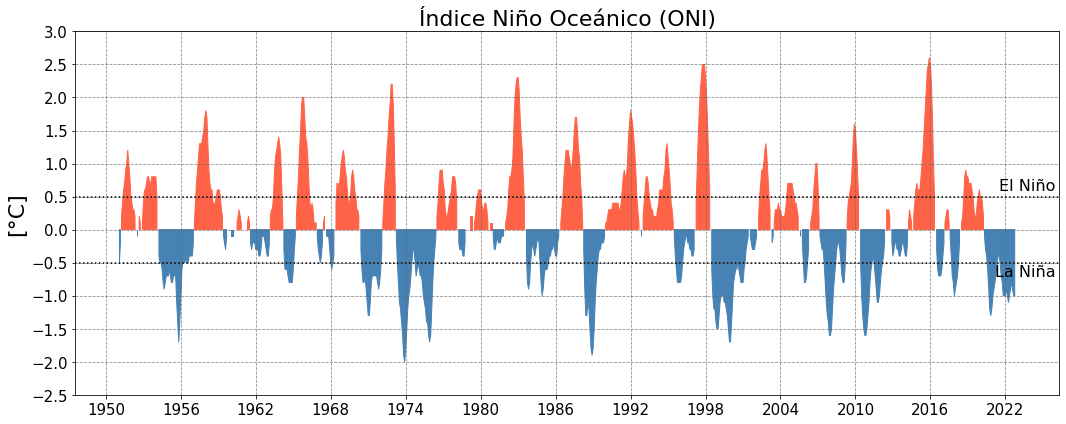

In [18]:
#fig, ax = figure(figsize=(15, 6))
def Oni_Soi(data1,data2,titulo):

  fig, ax = plt.subplots(figsize=(15, 6))

  #ax.plot(df.index, df.oni.values, color="black", linewidth=1)
  ax.fill_between(data1, data2, where=data2 > 0, color='tomato')
  ax.fill_between(data1,data2, where=data2< 0, color='steelblue')

  ax.set_yticks(np.linspace(-2.5, 3, 12)),plt.xticks(fontsize = 15),plt.yticks(fontsize = 15),ax.set_ylabel('[°C]',fontsize = 22)

  ax.set_title(titulo, fontsize=22)

  ax.grid(axis='x', linestyle = '--', alpha = 0.75, color = 'dimgrey'),plt.axhline(0.5,color='black',linewidth=1.5,linestyle='dotted')
  ax.grid(axis='y', linestyle = '--', alpha = 0.75, color = 'dimgrey'),plt.axhline(-0.5,color='black',linewidth=1.5,linestyle='dotted')

  ax.xaxis.set_major_locator(mdates.YearLocator(6)) # CADA 5 AÑOS 
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # FORMATO DE LA FECHA :v ? xd  

  ax.text(18800,0.6, 'El Niño', fontsize=16)
  ax.text(18700,-0.7, 'La Niña', fontsize=16)

  #ax.set_facecolor('snow')
  plt.tight_layout()
  plt.show()
  fig.savefig(path + f'ONI.jpg', 
                  transparent = False, pad_inches = 0.1, dpi = 700, bbox_inches = 'tight')
Oni_Soi(df_largo.index,df_largo['ONI'],'Índice Niño Oceánico (ONI)')